# 📜Summary
**Introduction:** Efficient operations in the airline industry hinge on maximizing the number of flights to optimize revenue. However, maintaining a tight schedule poses a significant risk of network delays. A single delayed flight not only impacts its immediate successor but can ripple through subsequent flights, amplifying disruptions across the network. This is why Airlines does it best to improve their On-Time Performance.

**Problem:** How can we maximize the number of flights while mitigating the risk of disruption?

**Hypothesis:** If we are able to know the chances of a flight being delayed, we  can plan our flight schedules better.

**Goal:** Predict the probability of delays for flights.

[kaggle](https://www.kaggle.com/code/fiftythirtyfour/usa-airline-on-time-performance/edit)

# 🌳Editor's Notes
## 🌿Iterate Fast
Always favor to do iteration fast. Work on a sample. Process the data and save it if you only need to do it once.

## 🌿Always use "g" when exploring Data.
Explore data using variable g and make sure you don't go out of the cell. Don't leave random variables lying around.

## 🌿Use Index when merging Data.
It is so much easier to merge dataframes using the indexes rather than doing a loop and dicts. Don't be intimidated by Multi-index, these are just tuples used as index.

- ✅Converted all date time to utc time.
- ✅Replaced airport placeholder codes to correct iata codes.
- ✅Calculated Scheduled and Actual Block times.
- 📌elapsed time and all other times are not minutes duration. It means something else.  

# 🤓Data Science

In [1]:
! pip install timezonefinder
! pip install meteostat
! pip install airportsdata

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime as dt
import pytz
from timezonefinder import TimezoneFinder
import airportsdata
from meteostat import Point, Daily, Stations
from datetime import datetime

warnings.filterwarnings("ignore")
pd.options.display.max_columns = 200
pd.options.display.max_rows = 400

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.3/912.3 kB 5.0 MB/s eta 0:00:00


In [2]:
### Load
df = pd.read_csv('/kaggle/input/flight-delays/flights.csv') ## Raw
# df = pd.read_parquet('df.parquet', engine='pyarrow') ## Preprocessed
airl = pd.read_csv('/kaggle/input/flight-delays/airlines.csv')
airp = pd.read_csv('/kaggle/input/airport-timezone/airports_timezone.csv')
timezone = dict(zip(airp['iata_code'], airp['timezone'].apply(lambda x: pytz.timezone(x)) ))

airportcode = airportsdata.load()
airportcode = pd.DataFrame(airportcode).T
airportcode = dict(zip(airportcode['iata'], airportcode['icao']))

In [3]:
## Get Timezones
def getTimezone(latlon):
    lat, lon = latlon
    tf = TimezoneFinder()
    return tf.timezone_at(lat=lat, lng=lon)

def processAirports(path):
    a = pd.read_csv(path)
    a.columns = a.columns.str.lower()

    a.loc[a['iata_code'] == "UST", ["latitude", "longitude"]] = (29.9581, -81.3416)
    a.loc[a['iata_code'] == "ECP", ["latitude", "longitude"]] = (30.3583, -85.7956)
    a.loc[a['iata_code'] == "PBG", ["latitude", "longitude"]] = (44.6509, -73.4663)

    a['timezone'] = a[['latitude', 'longitude']].apply(getTimezone, axis=1)
    a.to_csv('airports.csv')

## getting placeholder to iata
def getFreqAirport(a):
    plc = [x for x in a.unique() if len(x) > 3]
    chk = pd.Series([x for x in a if len(x) == 3])
    return (plc[0] if plc else None, chk.mode().iloc[0] if not chk.mode().empty else None)

def getIata(b):
    ## Get the most frequent airport based on the airline, flight number, and scheduled_departure time.
    ## It is rare that airlines would use a different flight number for the same origin-destination and departure time.
    b = b.groupby(['airline', 'flight_number', 'scheduled_departure'])['origin_airport'].apply(getFreqAirport).apply(pd.Series)
    b = b.reset_index().dropna()
    b.columns = ['airline', 'flight_number', 'scheduled_departure', 'placeholder', 'iata']
    b = b.groupby(['placeholder']).apply(lambda x: x['iata'].mode().iloc[0]).reset_index()
    b.columns = ['placeholder', 'iata']
    return dict(zip(b['placeholder'], b['iata']))

def convert_int_to_time(integer_time):
    if integer_time == 2400:
        hours = 0
        minutes = 0
    else:
        hours = integer_time // 100
        minutes = integer_time % 100

    return dt.time(hours, minutes)

### Cleaning
def cleanData(a):
    a.columns = a.columns.str.lower()
    a['origin_airport'] = a['origin_airport'].astype(str)
    a['destination_airport'] = a['destination_airport'].astype(str)
    a['scheduled_departure'] = [convert_int_to_time(x) for x in a['scheduled_departure']]
    a['scheduled_arrival'] = [convert_int_to_time(x) for x in a['scheduled_arrival']]
    a['departure_time'] = [convert_int_to_time(x) for x in a['departure_time'].fillna(0).astype(int)]
    a['arrival_time'] = [convert_int_to_time(x) for x in a['arrival_time'].fillna(0).astype(int)]
    
    a['std_ls_date'] = pd.to_datetime(a[['year', 'month', 'day']])

    a['std_ls_date_time'] = pd.to_datetime(a['std_ls_date'].astype(str) + ' ' + a['scheduled_departure'].astype(str))
    a['sta_ls_date_time'] = a['std_ls_date_time'] + pd.to_timedelta(a['scheduled_time'], unit='m', errors='coerce')
    ## Local time is based on origin airport to be consistent in converting to UTC.
    a['atd_ls_date_time'] = a['std_ls_date_time'] + pd.to_timedelta(a['departure_delay'], unit='m', errors='coerce')
    a['ata_ls_date_time'] = a['sta_ls_date_time'] + pd.to_timedelta(a['arrival_delay'], unit='m', errors='coerce')

    a['anchor'] = a['airline'] + [str(x).zfill(5) for x in a['flight_number']] + '|' + a['std_ls_date'].dt.strftime('%Y-%m-%d') + '|' + df['origin_airport'].astype(str)
    a['otp_dep15'] = np.where(a['departure_delay'] > 15, 0.0, 1.0)
    return a

def mapData(a, tz, ia, ac):
    ### Replace placeholder for October with actual airport iata codes.
    a['origin_airport'] = a['origin_airport'].replace(ia)
    a['destination_airport'] = a['destination_airport'].replace(ia)
    a['orig_timezone'] = a['origin_airport'].map(tz)    
    a['dest_timezone'] = a['destination_airport'].map(tz)    
    a['origin_icao'] = a['origin_airport'].map(ac)
    a['destination_icao'] = a['destination_airport'].map(ac)
    return a

def convertUTC(a):
    ### Convert local time of departure and arrival to UTC time based on origin timezone.
    a['std_z_date_time'] = a.apply(
        lambda row: row['std_ls_date_time']
        .tz_localize(row['orig_timezone'], ambiguous=True, nonexistent='shift_forward')
        .tz_convert('UTC').replace(tzinfo=None), axis=1)
    
    a['sta_z_date_time'] = a.apply(
        lambda row: row['sta_ls_date_time']
        .tz_localize(row['orig_timezone'], ambiguous=True, nonexistent='shift_forward')
        .tz_convert('UTC').replace(tzinfo=None), axis=1)
    a['atd_z_date_time'] = a.apply(
        lambda row: row['atd_ls_date_time']
        .tz_localize(row['orig_timezone'], ambiguous=True, nonexistent='shift_forward')
        .tz_convert('UTC').replace(tzinfo=None), axis=1)
    a['ata_z_date_time'] = a.apply(
        lambda row: row['ata_ls_date_time']
        .tz_localize(row['orig_timezone'], ambiguous=True, nonexistent='shift_forward')
        .tz_convert('UTC').replace(tzinfo=None), axis=1)
    
    a['std_z_date'] = pd.to_datetime(a['std_z_date_time'].dt.date)
    
    a['dep_banks'] = pd.cut(a['std_ls_date_time'].dt.hour
                            , bins=[0, 9, 12, 17, 20]
                            , labels=['pre-morning', 'morning', 'afternoon', 'night'])
    
    return a

def getWeather(a):
    wstation = Stations()
    wstation = wstation.fetch()['icao'].dropna().reset_index().set_index('icao')
    a.loc[a['origin_airport'] == 'ISN', 'origin_icao'] = 'KISN'
    a.loc[a['origin_airport'] == 'LAW', 'origin_icao'] = 'KFSI'
    
    a['station'] = a['origin_icao'].map(wstation['id'])
    
    h = Daily(list(set(a['station'].values))).fetch()
    h.index.names = ['station', 'std_z_date']
    a = a.set_index(['station', 'std_z_date'])
    a = pd.merge(a, h, left_index=True, right_index=True, how='left')
    return a.reset_index()

In [4]:
# Execute

### processAirports('/kaggle/input/flight-delays/airports.csv', index=False) ## Process this once, then save.
df = cleanData(df)

iatacodes = getIata(df) ## Detour. Get Iata codes for missing stations on October.
iatacodes['10577'] = 'BGM' ## Manually added these flights because they are new for October.
iatacodes['10666'] = 'BLI'

df = mapData(df, timezone, iatacodes, airportcode)
df = convertUTC(df)
df = getWeather(df)
df.drop(['orig_timezone', 'dest_timezone'], axis=1, inplace=True) ## Drop these before to_parquet.

# df.to_parquet('df.parquet', engine='pyarrow')

In [5]:
### Organize
dly = [x for x in df.columns if 'delay' in x]
num = [x for x in df.columns if df.dtypes[x] in ('float', 'int64')]
cat = [x for x in df.columns if df.dtypes[x] == "object"]
target = 'otp_dep15'
num.remove(target)

In [6]:
### Split
virgin = df.query('airline == "VX"')
train = virgin.loc[virgin['std_z_date_time'] <= '2015-11-01']
test = virgin.loc[virgin['std_z_date_time'] >= '2015-11-01']

## Target and Features

In [7]:
train.corr(numeric_only=True)[target].sort_values(ascending=False)

otp_dep15              1.000000
weather_delay          0.240896
distance               0.050609
air_time               0.049821
scheduled_time         0.044893
elapsed_time           0.043034
cancelled              0.035911
tmax                   0.027420
taxi_in                0.025821
day                    0.022906
pres                   0.018788
month                  0.013618
tavg                   0.010369
wdir                   0.007211
day_of_week           -0.003120
tmin                  -0.004467
diverted              -0.010584
security_delay        -0.012093
snow                  -0.023331
wspd                  -0.036206
prcp                  -0.056569
flight_number         -0.068817
taxi_out              -0.090503
airline_delay         -0.111997
wheels_on             -0.121943
air_system_delay      -0.135616
wheels_off            -0.176833
late_aircraft_delay   -0.294096
arrival_delay         -0.652103
departure_delay       -0.706167
year                        NaN
wpgt    

## Merger of American and US Airways
There was a Merger of American Airlines and US Airways in June 2015. Southwest, Delta and American Airlines have the biggest volume of flights in 2015.

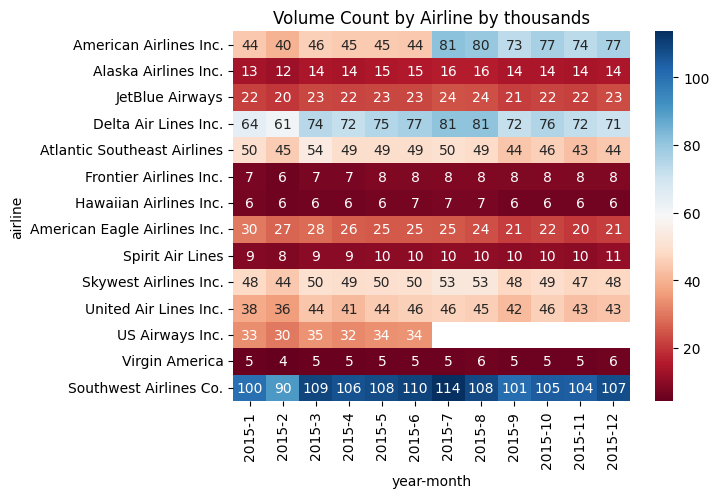

In [8]:
g = df.pivot_table('flight_number', index='airline'
              , columns=['year', 'month']
              , aggfunc='count') / 1000
g.index = g.index.map(airl.set_index('IATA_CODE')['AIRLINE'])
sns.heatmap(g, cmap='RdBu', annot=True, fmt='.0f')

plt.title("Volume Count by Airline by thousands");

## Airline Departure On-Time Performance.
Lower volume flights like Hawaiian, Virgin and Alaska Airlines are almost always on time. Delta and American airlines are also on time taking into consideration that they have more flights in 2015.

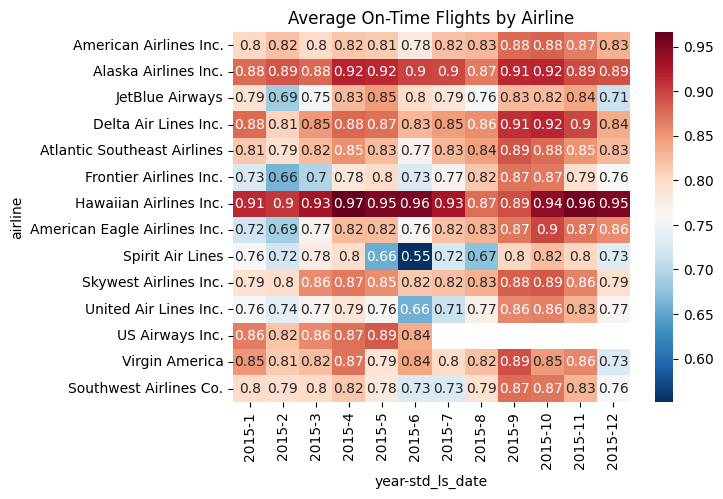

In [9]:
g = df.query('cancelled == 0 and diverted == 0')
g = g.pivot_table(target, index='airline'
             , columns=['year', g['std_ls_date'].dt.month]
             , aggfunc='mean')
g.index = g.index.map(airl.set_index('IATA_CODE')['AIRLINE'])
sns.heatmap(g, annot=True, cmap='RdBu_r')
plt.title('Average On-Time Flights by Airline');

## Flight Plan

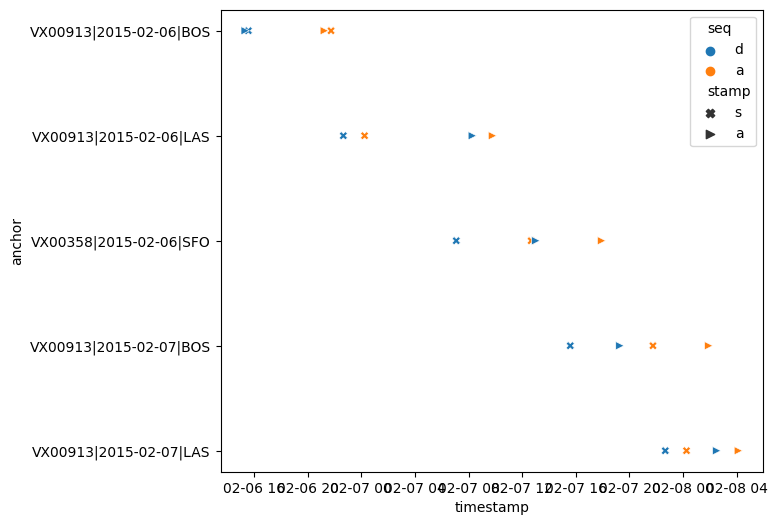

In [10]:
g = df.query('airline=="VX"')
g = g.query('tail_number == "N361VA"')
g = g.query('"2015-02-06" <= std_z_date <= "2015-02-07"')
g = g.loc[~g['departure_delay'].isnull()]
g = g[[
    'anchor'
    ,'std_z_date_time'
   , 'sta_z_date_time'    
   , 'atd_z_date_time'
   , 'ata_z_date_time'
      ]]

g = pd.melt(g, id_vars='anchor', var_name='marker', value_name='timestamp')
g['stamp'] = g['marker'].str[0]
g['seq'] = g['marker'].str[2:3]
fig, ax = plt.subplots(figsize=(7,6))
sns.scatterplot(g, x='timestamp', y='anchor'
                 , hue='seq'
                 , style='stamp'
                 , markers={'s': 'X', 'a': '>'}
                 , ax=ax);

## 🌧️Weather
The biggest factor why flights are delayed are because of the weather. I need the icao station ids to connect weather data to each airport, flights. The ICAO is similar to the IATA, it just has an extra character at the beginning that indicates the country that the station is in. 

In [11]:
g = df#.loc[df['origin_airport'].isin(['LAX', 'SFO'])]
g = g.groupby(['station', 'origin_icao', 'origin_airport'], dropna=False)[['tavg', 'tmin']].max()
g.head()

,,,tavg,tmin
station,origin_icao,origin_airport,,
56FNV,KMHT,MHT,NaN,NaN
70026,PABR,BRW,13.7,8.9
70133,PAOT,OTZ,20.3,17.2
70200,PAOM,OME,19.8,15.0
70219,PABE,BET,19.8,13.3


In [12]:
g = train

# g = g.groupby(['origin_airport', g['std_ls_date_time'].dt.hour])
# g = g.agg({
#     'otp_dep15': ['mean', 'count', 'sum']
#     , 'cancelled': ['sum']
# })

g = g.pivot_table(values = 'otp_dep15'
              , index=g['dep_banks']
              , columns='origin_airport'
              , aggfunc=['mean'])
g.style.background_gradient('Reds', axis=None)

In [13]:
g = train
g = g.query('origin_airport == "SFO"')
g.groupby([g['dep_banks']])['flight_number'].count()

dep_banks
pre-morning    4080
morning        1988
afternoon      4853
night          2200
Name: flight_number, dtype: int64

Departure Banks.
The flight numbers are just a variation of departure banks and a the destination.
I need to club them together to make sense of it.

# 🤖Machine

## Pipeline

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

In [15]:
class DataSelect(BaseEstimator, TransformerMixin):
    def __init__(self, att):
        self.att = att
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.att]

In [16]:
num_pp = Pipeline([
    ('dataselect', DataSelect([
        'tavg', 'tmin', 'tmax', 'prcp'
        , 'snow', 'wdir', 'wspd', 'wpgt'
        , 'pres', 'tsun'
    ]))
    , ('impute', SimpleImputer(strategy='mean'))
    , ('scaler', StandardScaler())
])

cat_pp = Pipeline([
    ('dataselect', DataSelect([
     'airline'
        , 'dep_banks'
        , 'origin_airport'
    ]))
    , ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

pipe = FeatureUnion([
    ('num_pp', num_pp)
    , ('cat_pp', cat_pp)
])

pipe.fit(train)
train_pp = pipe.transform(train)
test_pp = pipe.transform(test)

Now, that I have everything and all the choices, I don't know what to do next.
What do I know so far?
This is my time. No one is here.
I just need to keep at it.
I am in my space.
Actions:
- [ ] Explore the data

## Model

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [18]:
gnb = GaussianNB()
gnb.fit(train_pp, train[target])

GaussianNB()

In [19]:
cross_val_score(gnb, train_pp, train[target]).mean()

0.7922421295006774

In [20]:
cross_val_score(gnb, test_pp, test[target]).mean()

0.5419895324520174

In [21]:
machines = [
    GaussianNB()
#     , SVC()
    , RandomForestClassifier(random_state=0)
]

def getBaseline(lst, X, y):
    rt = []
    for m in machines:
        m.fit(X, y)
        rt.append({
            'model': m
            , 'base': cross_val_score(m, X, y).mean()
        })
    return pd.DataFrame(rt)

models = getBaseline(machines, train_pp,  train[target])
models

,model,base
0,GaussianNB(),0.792242
1,"(DecisionTreeClassifier(max_features='sqrt', r...",0.789298


In [22]:
models.iloc[1].model

RandomForestClassifier(random_state=0)

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_predict

def getScores(m, X, y):
    prediction = cross_val_predict(m, X, y)
    return {
        'accuracy': accuracy_score(y, prediction)
        , 'precision': precision_score(y, prediction)
        , 'recall': recall_score(y, prediction)
        , 'f1_score': f1_score(y, prediction)
        , 'roc_auc_score': roc_auc_score(y, prediction)
    }

scores = pd.DataFrame({
    'tr_base': getScores(models.iloc[1].model, train_pp, train[target])
#     , 'tr_tune': getScores(model_tune, train_pre, train[target])
    , 'te_base': getScores(models.iloc[1].model, test_pp, test[target])
#     , 'te_tune': getScores(model_tune, test_pre, test[target])
})

# scores['tr_diff'] = (scores['tr_tune'] / scores['tr_base'] -1) * 100
# scores['te_diff'] = (scores['te_tune'] / scores['te_base'] -1) * 100
# scores.drop(['tr_base', 'te_base'], axis=1, inplace=True)
scores

,tr_base,te_base
accuracy,0.789297,0.560591
precision,0.833574,0.737727
recall,0.934319,0.694336
f1_score,0.881076,0.715374
roc_auc_score,0.493814,0.367658


# Residual Analysis

# Submission

In [24]:
# %load_ext autoreload
# %autoreload 2
# import datawarehouse as dw
# dw.uploadData(df, "aviation", "ontimeperformance_v01")